Statistical Analysis

In [37]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd 
import contextily as ctx
from shapely.geometry import Point
import math
import numpy as np


load and clean data

In [38]:
main_data = pd.read_csv('../data/processed_data/new-york_ny_processed.csv')

In [39]:
main_data = main_data.drop('PropertyId', axis=1)
# Ensure all data is numeric before calculating the correlation matrix
main_data = main_data.apply(pd.to_numeric, errors='ignore')
lower_cap = main_data['MaxRent'].quantile(0.00)
upper_cap = main_data['MaxRent'].quantile(0.995)
main_data['MaxRent'] = main_data['MaxRent'].clip(lower_cap, upper_cap)

/tmp/ipykernel_134526/104269111.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  main_data = main_data.apply(pd.to_numeric, errors='ignore')


General Statistics 

In [40]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): print(main_data.describe())


         Latitude   Longitude  ReviewScore  Neighborhood_Label     Leisure  \
count  284.000000  284.000000   284.000000          284.000000  284.000000   
mean    40.811826  -74.017691     3.797535           14.345070    6.478873   
std      0.349590    0.386695     1.884143            6.452376    3.358904   
min     40.645561  -76.838357     0.000000            1.000000    0.000000   
25%     40.731931  -73.991872     3.900000           11.000000    4.000000   
50%     40.762377  -73.981761     4.700000           13.000000    8.000000   
75%     40.773428  -73.966433     4.800000           18.000000    8.000000   
max     43.293764  -73.336196     5.000000           28.000000   26.000000   

       Technology    Services    Location  Fitness & Wellness  \
count  284.000000  284.000000  284.000000          284.000000   
mean     4.394366    2.700704    5.542254            0.200704   
std      1.775203    2.889948    2.420826            0.401234   
min      0.000000    0.000000    0.00

distribution of rent prices 

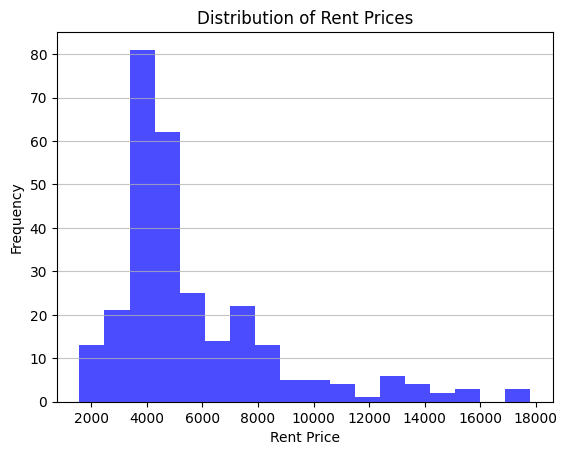

In [41]:

plt.hist(main_data['MaxRent'], bins='auto', color='blue', alpha=0.7)
plt.title('Distribution of Rent Prices')
plt.xlabel('Rent Price')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Linear Relationship between sqfoot and rent

Text(0.5, 1.0, 'Rent vs. Square Footage')

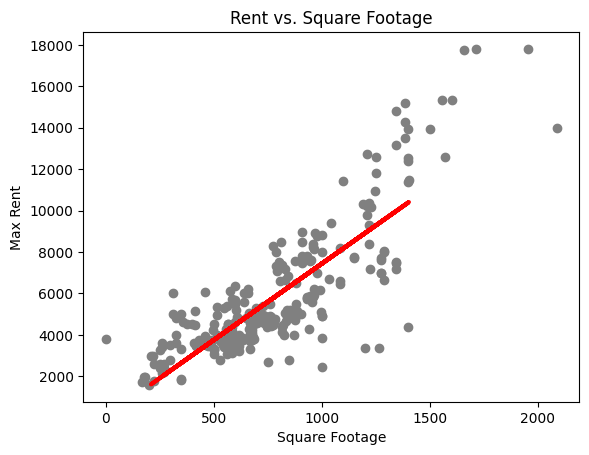

In [42]:
X = main_data[['SquareFootage']]
y = main_data['MaxRent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.scatter(main_data['SquareFootage'], main_data['MaxRent'], color='grey')
plt.plot(X_test, y_pred, color='red', linewidth=3, label='Predicted Rent')
plt.xlabel('Square Footage')
plt.ylabel('Max Rent')
plt.title('Rent vs. Square Footage')

Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix')

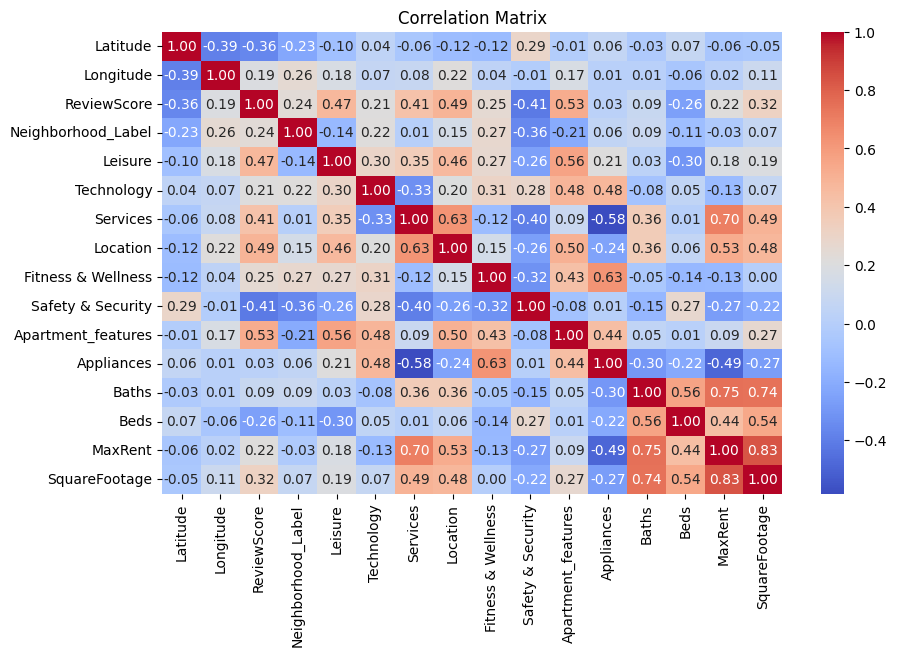

In [43]:
plt.figure(figsize=(10,6))
corr_matrix = main_data.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')


Visualizing Neighborhoods based on rent and amount

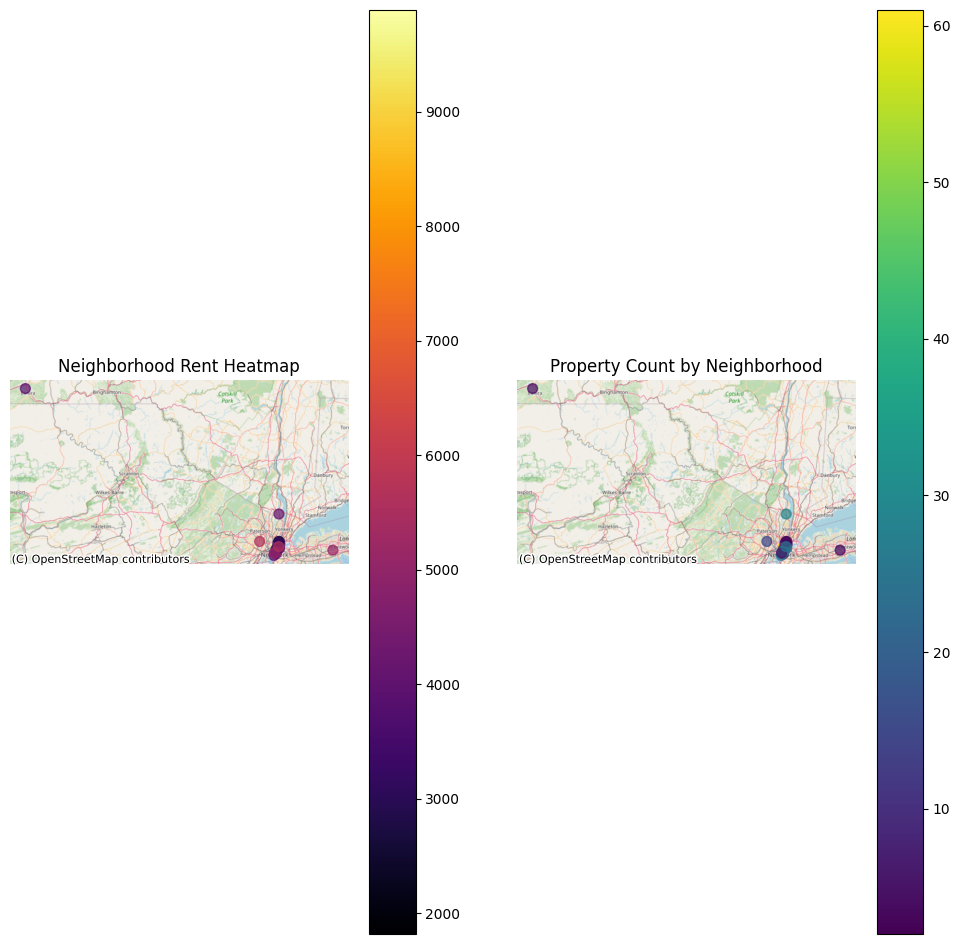

In [44]:
# main_data = main_data[(main_data['Latitude'] <= 31)]


neighborhoods = main_data.groupby('Neighborhood_Label').agg(
    MaxRent_Mean=('MaxRent', 'mean'),
    MaxRent_Std=('MaxRent', 'std'),
    Latitude_Mean=('Latitude', 'mean'),
    Longitude_Mean=('Longitude', 'mean'),
    Property_Count=('Neighborhood_Label', 'size')
)

# Creating a GeoDataFrame
geometry = [Point(xy) for xy in zip(neighborhoods['Longitude_Mean'], neighborhoods['Latitude_Mean'])]
gdf = gpd.GeoDataFrame(neighborhoods, geometry=geometry)
gdf.crs = 'EPSG:4326'
gdf = gdf.to_crs(epsg=3857)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

# Plot 1: Heatmap based on MaxRent_Mean
gdf.plot(ax=ax1, marker='o', column='MaxRent_Mean', cmap='inferno', legend=True, markersize=50, alpha=0.7)
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
ax1.set_axis_off()
ax1.set_title('Neighborhood Rent Heatmap')

# Plot 2: Heatmap based on Property_Count
gdf.plot(ax=ax2, marker='o', column='Property_Count', cmap='viridis', legend=True, markersize=50, alpha=0.7)
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik)
ax2.set_axis_off()
ax2.set_title('Property Count by Neighborhood')


plt.show()